# Navigation

---

In this notebook, you will see the Banan Navigation Project for the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## 1. Start the Environment

Please install all dependencies as explained in the Getting Started section in the [README.MD](https://github.com/trobar/navigation/blob/master/README.md) 

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# 2. The Algorithm

The algorithm is based on a Deep-Q-Learning Algorithms with experience replay and fixed-Q-targets. The algorithm conists
of three main parts:
    
* A deep neural network, to map environment states to action values
* An agent class to select an action using the neural network and update the neural network based on reward received from that action.
* The training class which brings together the neural network and the agent


### The Neural Network
A simple deep neural network (2 hidden layers) is used to map states to action values. 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


### The Agent and ReplayBuffer
The Agent class contains the following function

* init: Initialize the two networks (local and target) and the Replay Buffer
* step: The agent stores the results of the action, such as reward, new_state etc in the ReplayBuffer. If enough examples are stored in the ReplayBuffer it uses them to conduct a batch learning process.
* act: Using an epsilon greedy policy the agent select the Q-action values from the local network 
* learn: Optimizes the local network using backpropagation (AdamOptimizer), but takes the Q-targets from the target network.
* soft_update: Copies parameters from the local to the target network

In [16]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [17]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128 #64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 10 #4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        #Get the state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        #Just a forward push to calculate the outputs
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        
        #Activate training mode    
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)




### The Training Class
The training class iterates over 1000 episodes. For each episode the environment is reset and every 100 episode the average score is displayed

In [19]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]     
            next_state = env_info.vector_observations[0] 
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            score += reward                              
            state = next_state   
            
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores

## 2. See a trained agent in action

In the next code cell, you'll see a trained agent in action. 

Watch a video here: https://youtu.be/Uq9-nHRxtSU



In [25]:
import dill as pickle

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

agent = Agent(state_size=s, action_size=a, seed=0)

# load the neural networks
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_local.pth'))
agent.qnetwork_target.load_state_dict(torch.load('checkpoint_target.pth'))

# Load the ReplayBuffer
with open('agent_memory.pkl', 'rb') as file:
    agent.memory = pickle.load(file)

# Disable training mode to view how the agent moves

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

scores = []                        
scores_window = deque(maxlen=100)  
    
for i_episode in range(1, 1):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    for t in range(1000):
        action = agent.act(state, 0)
        env_info = env.step(action)[brain_name]     
        next_state = env_info.vector_observations[0] 
        reward = env_info.rewards[0]                   
        done = env_info.local_done[0]
           
        agent.step(state, action, reward, next_state, done)
        score += reward                               
        state = next_state   
            
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

## Train your own agent

Watch a training video here: https://youtu.be/mRtfJDLXPhA

The plot of the agent's performance shows that the benachmark of an average score of 13 has been reached after 600 episodes and converges to a score of 16 after 1000 episodes.

Episode 100	Average Score: 0.34
Episode 200	Average Score: 3.13
Episode 300	Average Score: 4.88
Episode 400	Average Score: 8.67
Episode 500	Average Score: 11.32
Episode 600	Average Score: 14.48
Episode 700	Average Score: 15.39
Episode 800	Average Score: 15.54
Episode 900	Average Score: 16.06
Episode 1000	Average Score: 15.60


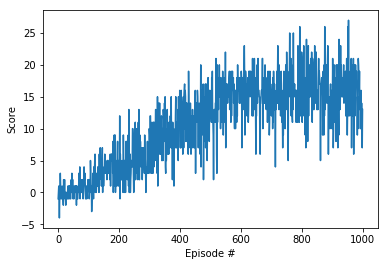

In [27]:

import matplotlib.pyplot as plt
import dill as pickle

%matplotlib inline

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
a = brain.vector_action_space_size

# examine the state space 
state = env_info.vector_observations[0]
s = len(state)


agent = Agent(state_size=s , action_size= a, seed=0)

scores = dqn()

torch.save(agent.qnetwork_local.state_dict(), 'your_checkpoint_local.pth')
torch.save(agent.qnetwork_target.state_dict(), 'your_checkpoint_target.pth')
with open('your_agent_memory.pkl', 'wb') as file:
    pickle.dump(agent.memory, file)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()

## Future Ideas

Implement a double DQN, a dueling DQN, and/or prioritized experience replay.